# Предсказание выходной температуры сплава при плавке стали 

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Кратко, процесс плавки представляет собой замер температуры, нагревание сплава электродами, добавление примесей, продувка газом и снова замер температуры. Процесс повторяется необходимое количество раз.  

**Цель работы:**  
Создать модель прогнозирования температуры сплава на последнем цикле плавки. Исходные данные - техническая информация(циклы нагрева и мощность электродов, информация о примесях, продувке газом и пр.) для чуть более 3000 процессов плавки.  
Метрика качества - MAE. Она должна быть не выше 6.8.

**Ход работы**
1. Исследование данных
2. Предобработка данных
3. Выбор и исследование нескольких моделей машинного обучения
4. Тестирование наиболее подходящей модели
5. Создание отчета по итогам проведенной работы

**-----------PEP----------- не забыть**

# Исследование данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Импортируем наши датасеты

In [3]:
try:
    data_arc = pd.read_csv('data_arc_new.csv')
    data_bulk_time = pd.read_csv('data_bulk_time_new.csv')
    data_gas = pd.read_csv('data_gas_new.csv')
    data_temp = pd.read_csv('data_temp_new.csv')
    data_temp = pd.read_csv('data_temp_new.csv')
    data_wire_time = pd.read_csv('data_wire_time_new.csv')

except:
    data_arc = pd.read_csv('/datasets/data_arc_new.csv')
    data_bulk_time = pd.read_csv('/datasets/data_bulk_time_new.csv')
    data_gas = pd.read_csv('/datasets/data_gas_new.csv')
    data_temp = pd.read_csv('/datasets/data_temp_new.csv')
    data_temp = pd.read_csv('/datasets/data_temp_new.csv')
    data_wire_time = pd.read_csv('/datasets/data_wire_time_new.csv')

Так как работаем мы с несколькими датасетами сразу, исследуем их по очереди, чтобы не запутаться

## Data_arc

`data_arc` - это датасет с данными об электродах, которые опускают в ковш, для плавки находящегося в нем стального сплава

### Общая информация о датасете

In [4]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [7]:
data_arc.head(10)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,0.220351
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,0.261665,0.205527
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.710297,0.484962
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.786322,0.542517
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.101678,0.820856


In [8]:
data_arc.describe()

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284


---
Явные пропуски в датасете отсутсвуют, во всех колонках 14876 значений.  
`key` - это номер партии. Если есть несколько строк с одинаковым значением key, то это разные циклы обработки.  
Если смотреть на описательные статистики, то сразу заметно отрицательное значение в поле `Реактивная мощность`. Дальше, как раз взглянем на столбцы с мощностью подробнее.  
Также, на этапе предобработке можно будет сгенерировать новые признаки: длительность(разница конца и начала нагрева) и полную мощность(по формуле).

### Смотрим признаки

**Активная мощность**

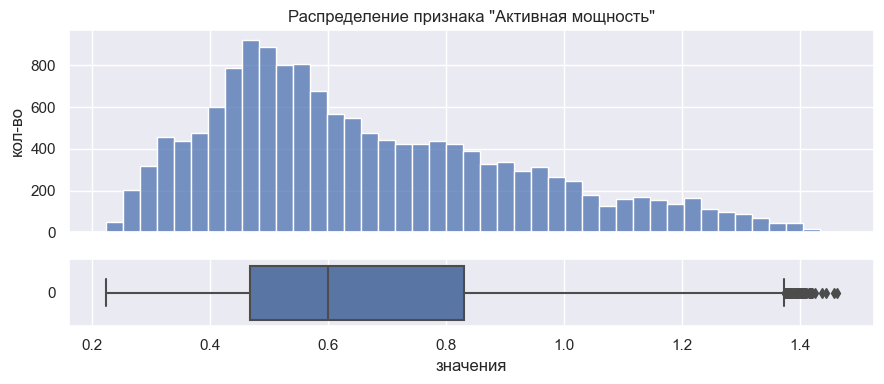

In [32]:
sns.set_theme()
fig, axes = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': [3, 1]}, figsize=(9, 4))
sns.histplot(data_arc['Активная мощность'], ax=axes[0])
sns.boxplot(data_arc['Активная мощность'], orient='h', ax=axes[1])
axes[0].set(title='Распределение признака "Активная мощность"')
axes[0].set(ylabel='кол-во')
axes[1].set(xlabel='значения')
plt.tight_layout()

Распределение похоже на нормальное, со смещением вправо. Аномалий или аномальных пиков на графиике нет.  
На диаграмме размаха есть значения, которые можно посчитать выбросами. Но точно сказать, выбросы это или технологическая норма нельзя, да и находятся они не так уж и далеко от границы "уса". Поэтому, будем считать их нормой

**Реактивная мощность**

Чтобы графики сильно не смещались из-за аномальных значений, исследуем их отдельно. В нашем случае, это отрицательные значения

In [36]:
print('Отрицательных значений:', len(data_arc[data_arc['Реактивная мощность'] < 0]))

Отрицательных значений: 1


Отлично, можно смело строить графики без этого выброса

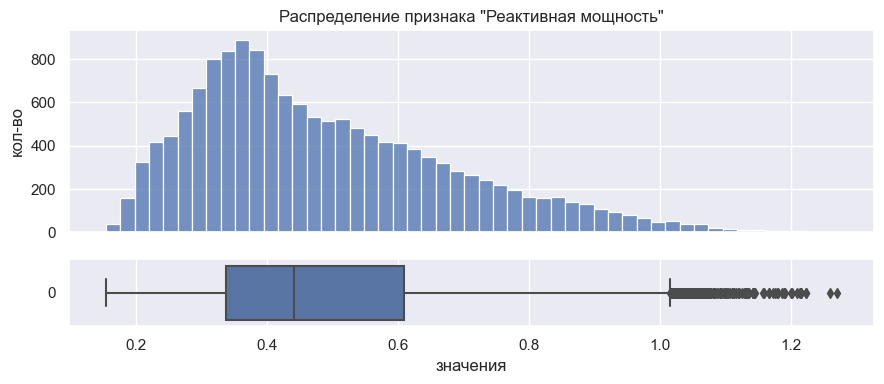

In [43]:
#уберем выброс, чтобы графики нормально отображались
data_react = data_arc[data_arc['Реактивная мощность'] > 0]

fig, axes = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': [3, 1]}, figsize=(9, 4))
sns.histplot(data_react['Реактивная мощность'], ax=axes[0])
sns.boxplot(data_react['Реактивная мощность'], orient='h', ax=axes[1])
axes[0].set(title='Распределение признака "Реактивная мощность"')
axes[0].set(ylabel='кол-во')
axes[1].set(xlabel='значения')
plt.tight_layout()

Получили распределение, близкое к нормальному со смещением вправо. Выброс всего один - отрицательное значение